In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Import files

In [ ]:
import pandas as pd
import numpy as np
import datetime
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold


#Part-1 : Outlier removal, feature extraction, missing value imputation and   feature engineering

In [ ]:
# Read data from CSV files
training_data_df = pd.read_csv("/content/drive/MyDrive/MS_NEU/7100_TimeSeries/Project/train.csv")
building_info_df = pd.read_csv('/content/drive/MyDrive/MS_NEU/7100_TimeSeries/Project/building_metadata.csv')
weather_info_df = pd.read_csv('/content/drive/MyDrive/MS_NEU/7100_TimeSeries/Project/weather_train.csv')

##Outlier removal and feature extraction 

In [ ]:
# Remove outliers
training_data_df = training_data_df [ training_data_df['building_id'] != 1099 ]
training_data_df = training_data_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [ ]:
weather_info_df["datetime"] = pd.to_datetime(weather_info_df["timestamp"])
weather_info_df["month"] = weather_info_df["datetime"].dt.month
weather_info_df["week"] = weather_info_df["datetime"].dt.week
weather_info_df["day"] = weather_info_df["datetime"].dt.day
air_temperature_fill_data = pd.DataFrame(weather_info_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


##Missing value imputation

In [ ]:
def missing_value_imputation(weather_info_df):
  
  # Find Missing Dates
  time_format = "%Y-%m-%d %H:%M:%S"
  start_date = datetime.datetime.strptime(weather_info_df['timestamp'].min(),time_format)
  end_date = datetime.datetime.strptime(weather_info_df['timestamp'].max(),time_format)
  total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
  hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

  missing_hours = []
  for site_id in range(16):
      site_hours = np.array(weather_info_df[weather_info_df['site_id'] == site_id]['timestamp'])
      new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
      new_rows['site_id'] = site_id
      weather_info_df = pd.concat([weather_info_df,new_rows])

      weather_info_df = weather_info_df.reset_index(drop=True)           

  # Add new Features
  weather_info_df["datetime"] = pd.to_datetime(weather_info_df["timestamp"])
  weather_info_df["day"] = weather_info_df["datetime"].dt.day
  weather_info_df["week"] = weather_info_df["datetime"].dt.week
  weather_info_df["month"] = weather_info_df["datetime"].dt.month

  # Reset Index for Fast Update
  weather_info_df = weather_info_df.set_index(['site_id','day','month'])

  air_temperature_fill_data = pd.DataFrame(weather_info_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
  weather_info_df.update(air_temperature_fill_data,overwrite=False)

  # Step 1
  cloud_coverage_fill_data = weather_info_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
  # Step 2
  cloud_coverage_fill_data = pd.DataFrame(cloud_coverage_fill_data.fillna(method='ffill'),columns=["cloud_coverage"])

  weather_info_df.update(cloud_coverage_fill_data,overwrite=False)

  due_temperature_fill_data = pd.DataFrame(weather_info_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
  weather_info_df.update(due_temperature_fill_data,overwrite=False)

  # Step 1
  sea_level_fill_data = weather_info_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
  # Step 2
  sea_level_fill_data = pd.DataFrame(sea_level_fill_data.fillna(method='ffill'),columns=['sea_level_pressure'])

  weather_info_df.update(sea_level_fill_data,overwrite=False)

  wind_direction_fill_data =  pd.DataFrame(weather_info_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
  weather_info_df.update(wind_direction_fill_data,overwrite=False)

  wind_speed_fill_data =  pd.DataFrame(weather_info_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
  weather_info_df.update(wind_speed_fill_data,overwrite=False)

  # Step 1
  precip_depth_fill_data = weather_info_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
  # Step 2
  precip_depth_fill_data = pd.DataFrame(precip_depth_fill_data.fillna(method='ffill'),columns=['precip_depth_1_hr'])

  weather_info_df.update(precip_depth_fill_data,overwrite=False)

  weather_info_df = weather_info_df.reset_index()
  weather_info_df = weather_info_df.drop(['datetime','day','week','month'],axis=1)
      
  return weather_info_df

In [ ]:
weather_info_df = missing_value_imputation(weather_info_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [ ]:
weather_info_df

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.000000,20.000000,-0.173913,1019.700000,0.000000,0.000000
1,0,2016-01-01 01:00:00,24.400000,4.285714,21.100000,-1.000000,1020.200000,70.000000,1.500000
2,0,2016-01-01 02:00:00,22.800000,2.000000,21.100000,0.000000,1020.200000,0.000000,0.000000
3,0,2016-01-01 03:00:00,21.100000,2.000000,20.600000,0.000000,1020.100000,0.000000,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.000000,20.000000,-1.000000,1020.000000,250.000000,2.600000
...,...,...,...,...,...,...,...,...,...
140539,15,2016-12-09 10:00:00,-3.534783,4.000000,-7.013043,-1.000000,1019.817391,290.869565,6.565217
140540,15,2016-12-17 07:00:00,-5.856522,1.500000,-8.982609,0.066667,1015.613043,157.391304,5.695652
140541,15,2016-12-20 06:00:00,-8.865217,0.000000,-12.730435,3.800000,1032.981818,135.652174,3.500000
140542,15,2016-12-24 05:00:00,2.630435,1.200000,-2.760870,-1.000000,1020.921739,200.869565,4.847826


##Feature Engineering

In [ ]:
def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                    "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                    "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                    "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                    "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                    "2019-01-01"]
    df["is_holiday"] = (df.timestamp.isin(holidays)).astype(int)
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # Remove Unused Columns
    drop = ["year_built","floor_count"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [ ]:
training_data_df = training_data_df.merge(building_info_df, left_on='building_id',right_on='building_id',how='left')
training_data_df = training_data_df.merge(weather_info_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
del weather_info_df
gc.collect()

0

In [ ]:
train_df_temp_output = features_engineering(training_data_df)

In [ ]:
training_data_df = train_df_temp_output.drop(columns="timestamp")

In [ ]:
train_df_temp_output = train_df_temp_output[train_df_temp_output.building_id < 291]

##Save dataframe to CSV file for future use 

In [ ]:
train_df_temp_output.to_csv('/content/drive/MyDrive/MS_NEU/7100_TimeSeries/Project/training_features_file.csv')

---

#Part-2 : Regression Models Linear Regression and Decision Tree

##Read dataframe from CSV file (No need to run previous section)

In [ ]:
train_read_df = pd.read_csv('/content/drive/MyDrive/MS_NEU/7100_TimeSeries/Project/training_features_file.csv')

---

In [ ]:
train_read_df = train_read_df[train_read_df.building_id < 291]

In [ ]:
train_read_df

,Unnamed: 0,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,weekend,is_holiday
0,0,105,0,2016-01-01 00:00:00,23.3036,1,0,10.832181,3.8,0.000000,2.4,0.0,1020.9,240.0,3.1,0,4,1
1,1,106,0,2016-01-01 00:00:00,0.3746,1,0,8.589514,3.8,0.000000,2.4,0.0,1020.9,240.0,3.1,0,4,1
2,2,106,3,2016-01-01 00:00:00,0.0000,1,0,8.589514,3.8,0.000000,2.4,0.0,1020.9,240.0,3.1,0,4,1
3,3,107,0,2016-01-01 00:00:00,175.1840,1,0,11.487946,3.8,0.000000,2.4,0.0,1020.9,240.0,3.1,0,4,1
4,4,108,0,2016-01-01 00:00:00,91.2653,1,0,11.309352,3.8,0.000000,2.4,0.0,1020.9,240.0,3.1,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3814214,19850532,287,3,2016-12-31 23:00:00,0.0000,2,6,10.425668,16.7,5.666667,10.0,0.0,1011.0,250.0,2.6,23,5,0
3814215,19850533,288,0,2016-12-31 23:00:00,5.6200,2,1,9.281172,16.7,5.666667,10.0,0.0,1011.0,250.0,2.6,23,5,0
3814216,19850534,289,0,2016-12-31 23:00:00,11.8600,2,1,9.176473,16.7,5.666667,10.0,0.0,1011.0,250.0,2.6,23,5,0
3814217,19850535,290,0,2016-12-31 23:00:00,22.2000,2,6,10.853851,16.7,5.666667,10.0,0.0,1011.0,250.0,2.6,23,5,0


In [ ]:
train_read_df = train_read_df.drop('Unnamed: 0',axis=1)
train_read_df = train_read_df.drop('timestamp',axis=1)

In [ ]:
# Feature transformation (Log-tranformation) on meter reading
target = np.log1p(train_read_df["meter_reading"])
features = train_read_df.drop('meter_reading', axis = 1)
#del train_df
gc.collect()


492

In [ ]:
target

0          3.190624
1          0.318163
2          0.000000
3          5.171529
4          4.524668
             ...   
3814214    0.000000
3814215    1.890095
3814216    2.554122
3814217    3.144152
3814218    0.161949
Name: meter_reading, Length: 3814219, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


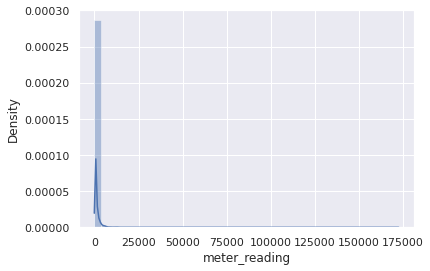

In [ ]:
import seaborn as sns
sns.set_theme()
x = sns.distplot(train_read_df["meter_reading"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


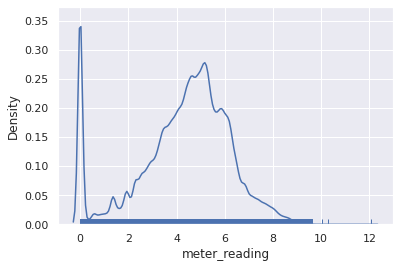

In [ ]:
x = sns.distplot(target, rug=True, hist=False)

In [ ]:
features.head()

,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,weekend,is_holiday
0,105,0,1,0,10.832181,3.8,0.0,2.4,0.0,1020.9,240.0,3.1,0,4,1
1,106,0,1,0,8.589514,3.8,0.0,2.4,0.0,1020.9,240.0,3.1,0,4,1
2,106,3,1,0,8.589514,3.8,0.0,2.4,0.0,1020.9,240.0,3.1,0,4,1
3,107,0,1,0,11.487946,3.8,0.0,2.4,0.0,1020.9,240.0,3.1,0,4,1
4,108,0,1,0,11.309352,3.8,0.0,2.4,0.0,1020.9,240.0,3.1,0,4,1


##Train and test data splitting

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2669953, 15)
(1144266, 15)
(2669953,)
(1144266,)


In [ ]:
# plot series
def plot_series(data, plot_name,title_name):
    plt.plot( data, color="blue", linewidth = 2,label='series')
    plt.title(title_name)
    plt.xlabel('Time',fontsize=10)
    plt.ylabel('Y',fontsize=10)
    plt.legend(fontsize=10)
    plt.savefig(plot_name)

    plt.show()
    

# plot for actual versus prediction results
def plot_actual_vs_pred( plot_name, y_test, y_pred): #test_start_index  
    plt.plot( y_test, color="blue", linewidth=3,label='Actual')
    plt.plot( y_pred, color="green", linewidth=3,label='Prediction')
    plt.xlabel('Time',fontsize=10)
    plt.ylabel('Y',fontsize=10)
    plt.legend(fontsize=10)
    plt.savefig(plot_name)

    plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_squared_log_error, r2_score

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
linear_reg_pred = reg.predict(X_test)
print("RMSE using Linear Regression",mean_squared_error(y_test,linear_reg_pred))
print("MAE using Linear Regression",mean_absolute_error(y_test,linear_reg_pred))
print("R2 score", r2_score(y_test,linear_reg_pred))

RMSE using Linear Regression 2.406503415969442
MAE using Linear Regression 1.1622863708104025
R2 score 0.37745249944789305


In [ ]:
y_test_aray = y_test.to_numpy()
y_test_aray


array([0.        , 4.78782502, 5.71158529, ..., 3.82131024, 4.20454335,
       6.33426493])

(1144266,)


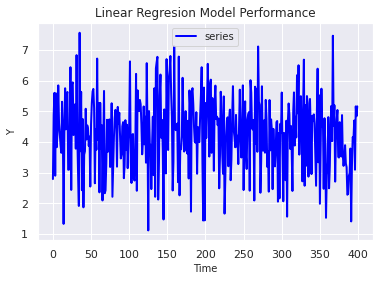

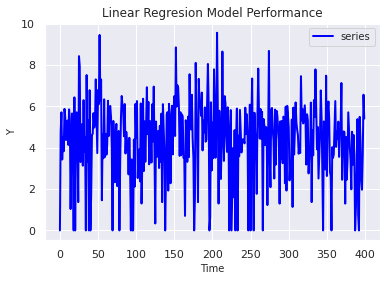

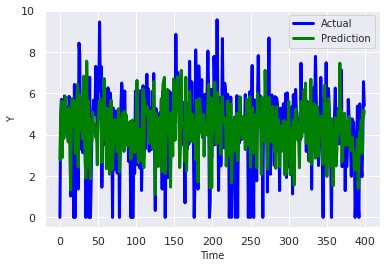

In [ ]:
plot_name = "Linear Regresion_actual_vs_pred.png"
title_name = "Linear Regresion Model Performance"
print(y_test_aray.shape)

plot_series(linear_reg_pred[0:400], plot_name, title_name)
plot_series(y_test_aray[0:400], plot_name, title_name)
plot_actual_vs_pred( plot_name, y_test_aray[0:400], linear_reg_pred[0:400])

###Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
regfit = DecisionTreeRegressor().fit(X_train,y_train)
dt_pred = regfit.predict(X_test)
print("RMSE using Decision Tree Regressor",mean_squared_error(y_test,dt_pred))
print("MAE using Decision Tree Regressor",mean_absolute_error(y_test,dt_pred))
print("R2 score", r2_score(y_test,dt_pred))

RMSE using Decision Tree Regressor 0.6050527238206584
MAE using Decision Tree Regressor 0.26707819723544396
R2 score 0.8434766149022669


(1144266,)


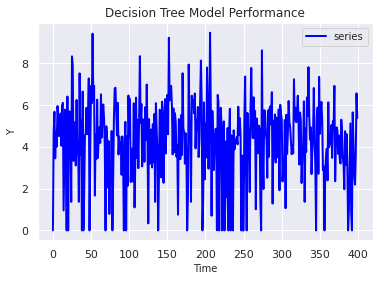

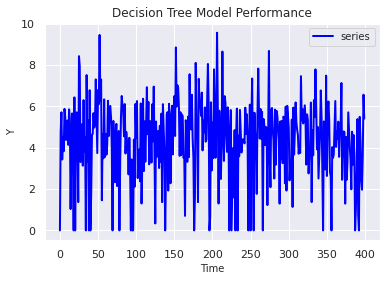

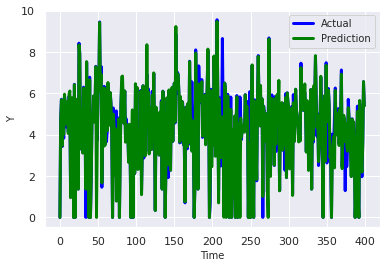

In [ ]:
plot_name = "Decision Tree actual_vs_pred.png"
title_name = "Decision Tree Model Performance"
print(y_test_aray.shape)

plot_series(dt_pred[0:400], plot_name, title_name)
plot_series(y_test_aray[0:400], plot_name, title_name)
plot_actual_vs_pred( plot_name, y_test_aray[0:400], dt_pred[0:400])

###Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rffit = RandomForestRegressor(n_estimators=20).fit(X_train,y_train)
rf_pred = rffit.predict(X_test)
print("RMSE using Decision Tree Regressor",mean_squared_error(y_test,rf_pred))
print("MAE using Decision Tree Regressor",mean_absolute_error(y_test,rf_pred))
print("R2 score", r2_score(y_test,rf_pred))

In [ ]:
plot_name = "Random Forest actual_vs_pred.png"
title_name = "Random Forest  Model Performance"
print(y_test_aray.shape)

plot_series(dt_pred[0:400], plot_name, title_name)
plot_series(y_test_aray[0:400], plot_name, title_name)
plot_actual_vs_pred( plot_name, y_test_aray[0:400], dt_pred[0:400])